In [4]:
import sys
import os
import pandas as pd
import numpy as np
from scipy import interpolate
from importlib import reload
from sklearn import preprocessing
import multiprocessing as mp
from functools import partial
import scipy
import pydmd 

# plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

import plotly.offline as go_offline
import plotly.graph_objects as go
import plotly.express as px

# local import
sys.path.append("../")
from utils.trackmate import dataEngineering as _tm
from utils.trackmate import spatialAnalysis as _stat
from utils.trackmate import woundHealing as _wh

from utils.visualization import generalPlots
from utils.visualization import vectorPlots 
from utils.visualization import leadingEdgePlots 
from utils.visualization import densityPlots 


/home/cstansbu/.local/lib/python3.8/site-packages/libpysal/weights/util.py:23: UserWarning:

geopandas not available. Some functionality will be disabled.



In [5]:
"""Load Data
"""
dir_path = "/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/WH06/analysis_files/scene14/"

LOW_INTENSITY_THRESHOLD = 0.4

data = _tm.load_trackmate_dir(dir_path)
df = _tm.merge_tracks_and_all(data)
df = _tm.clean_up_trackSpots(df, LOW_INTENSITY_THRESHOLD)
print(df.shape)

df.head()

(688966, 60)


Label_x      ID  TRACK_ID  QUALITY  POSITION_X  POSITION_Y  \
138     ID82185   82185         0   33.953      70.050      13.853   
5607    ID19267   19267         0   30.948      72.218      12.109   
9099    ID92446   92446         0   32.575      68.166      15.139   
12610   ID67493   67493         0   44.598      66.892      16.123   
15910  ID131074  131074         0   24.322      58.221      23.565   

       POSITION_Z  POSITION_T  FRAME  RADIUS  ...  CONFINMENT_RATIO  \
138             0       0.000      0       4  ...              0.12   
5607            0     781.498      1       4  ...              0.12   
9099            0    1562.996      2       4  ...              0.12   
12610           0    2344.494      3       4  ...              0.12   
15910           0    3125.992      4       4  ...              0.12   

       MEAN_STRAIGHT_LINE_SPEED  LINEARITY_OF_FORWARD_PROGRESSION  \
138                    0.000833                              0.12   
5607                   0.000833                              0.12   
9099                   0.000833                              0.12   
12610                  0.000833                              0.12   
15910                  0.000833                              0.12   

       TOTAL_ABSOLUTE_ANGLE_XY  TOTAL_ABSOLUTE_ANGLE_YZ  \
138                      1.438                      0.0   
5607                     1.438                      0.0   
9099                     1.438                      0.0   
12610                    1.438                      0.0   
15910                    1.438                      0.0   

       TOTAL_ABSOLUTE_ANGLE_ZX  STEP  NORMED_STEP  MEAN_INTENSITY01_SCALED  \
138                      1.571     0     0.000000                 1.000000   
5607                     1.571     1     0.000011                 0.000000   
9099                     1.571     2     0.000022                 0.837839   
12610                    1.571     3     0.000034                 0.864867   
15910                    1.571     4     0.000045                 0.918918   

       MEAN_INTENSITY_SCALED  
138                 1.000000  
5607                0.000000  
9099                0.837839  
12610               0.864867  
15910               0.918918  

[5 rows x 60 columns]

In [6]:
# list(df.columns)

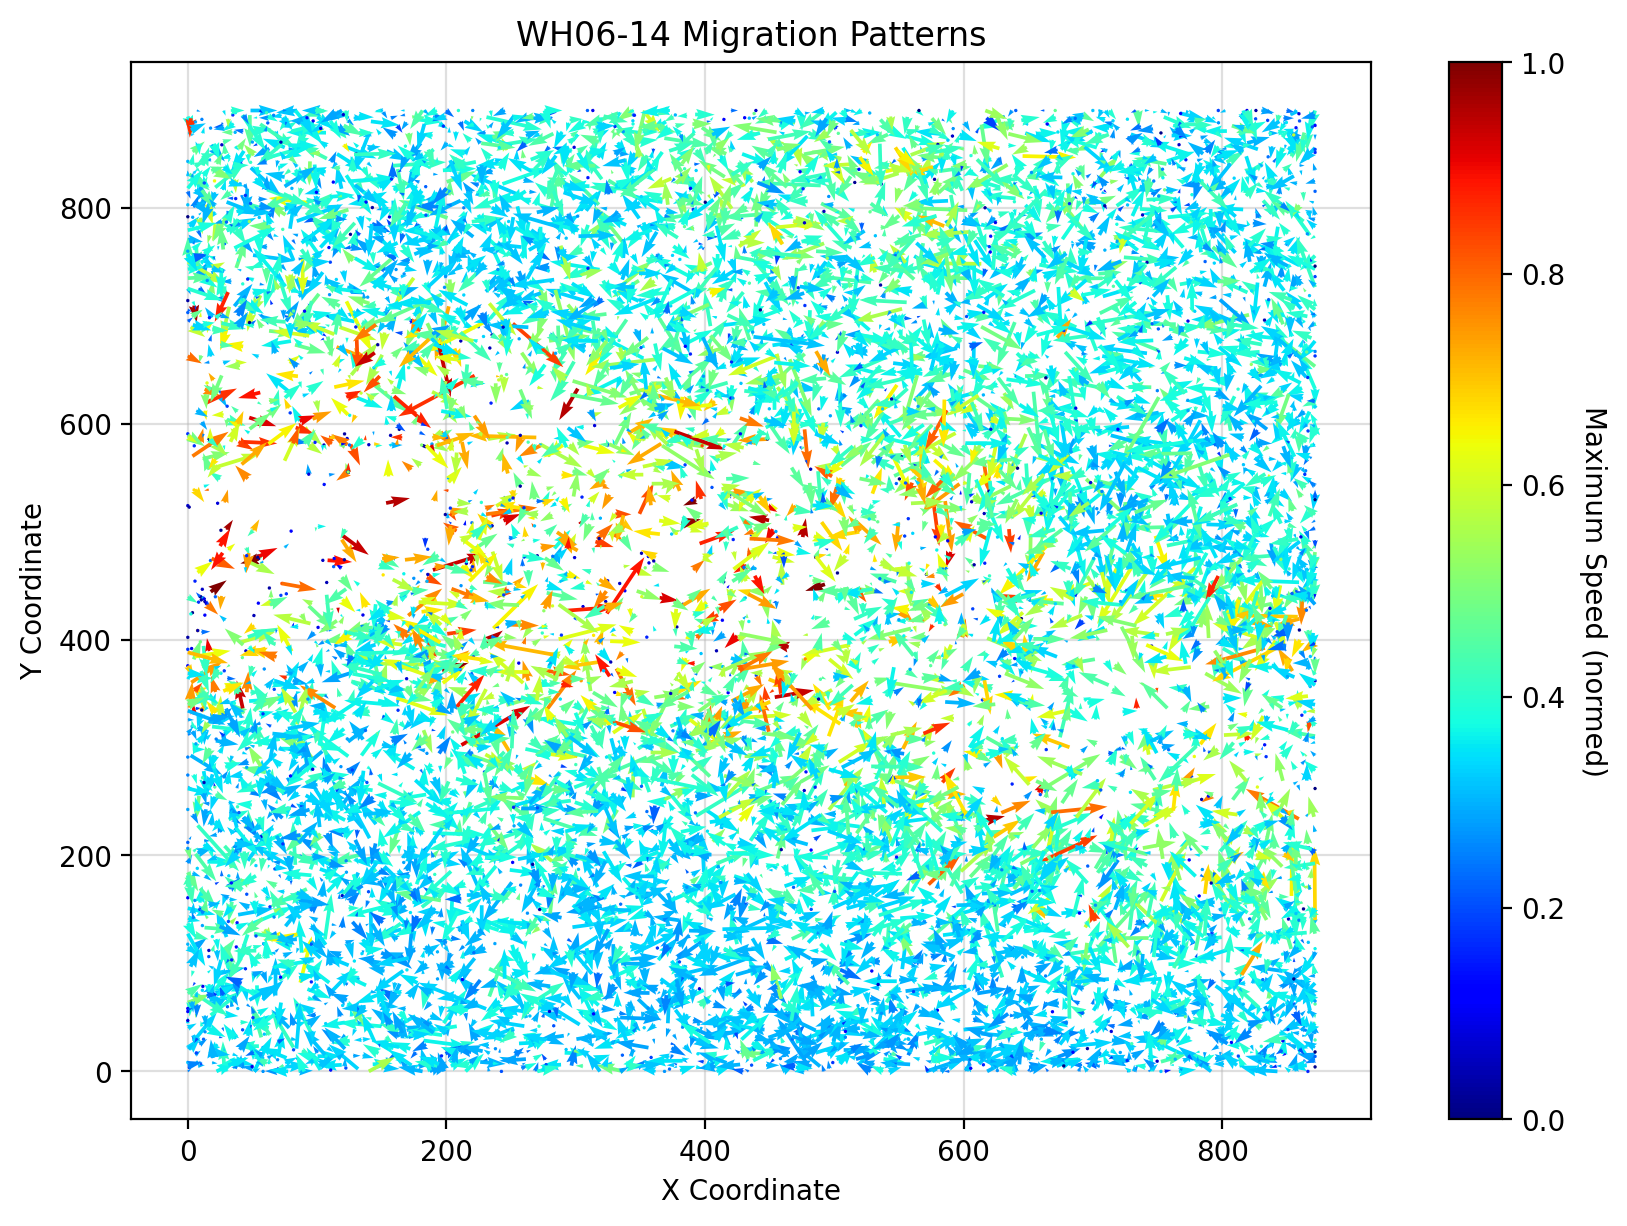

In [7]:
reload(vectorPlots)

matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = (10, 7)

q = vectorPlots.plot_quiver(df, 'TRACK_ID', 'TRACK_MAX_SPEED', scale=3, width=0.003)
    
cb = plt.colorbar(q, aspect=20)
cb.ax.get_yaxis().labelpad = 15
cb.ax.set_ylabel('Maximum Speed (normed)', rotation=270)

plt.ylabel("Y Coordinate")
plt.xlabel("X Coordinate")
plt.title("WH06-14 Migration Patterns")

plt.gca().set_axisbelow(True)
plt.grid(True, alpha=0.4)

/home/cstansbu/.local/lib/python3.8/site-packages/pointpats/centrography.py:229: RuntimeWarning:

Mean of empty slice.

/home/cstansbu/.local/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning:

invalid value encountered in true_divide

/home/cstansbu/.local/lib/python3.8/site-packages/pointpats/centrography.py:230: RuntimeWarning:

invalid value encountered in true_divide



Text(0.5, 0.8, 'Cell Initial and Final Densities')

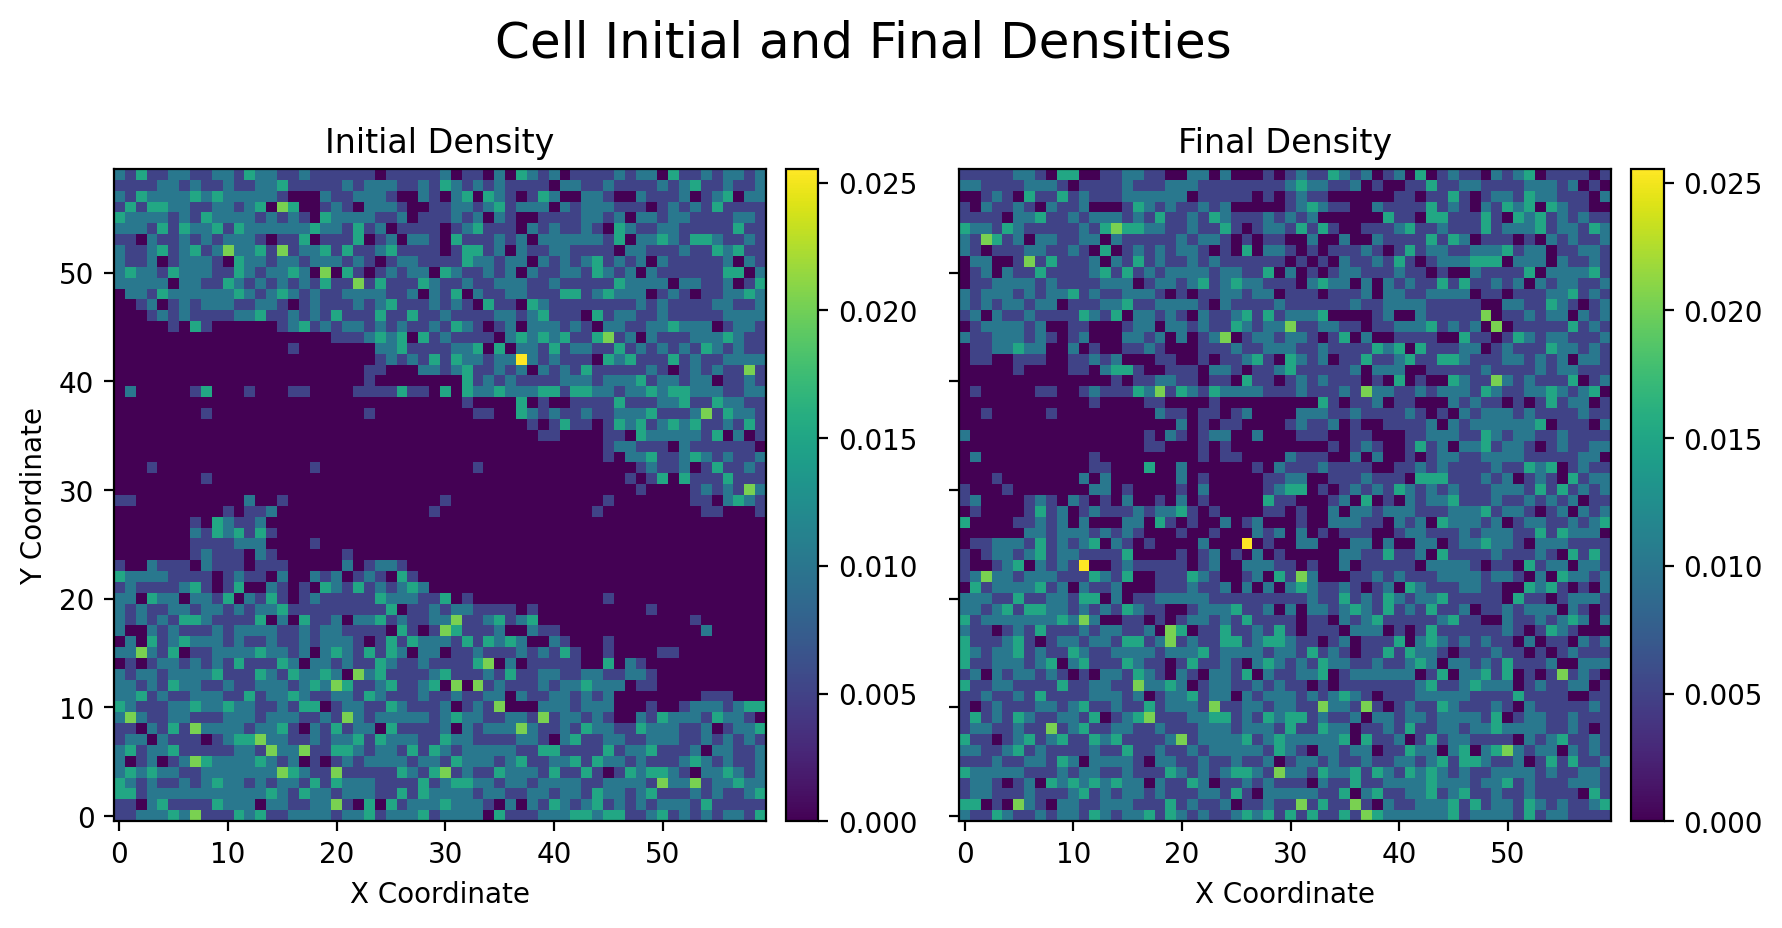

In [8]:
SIZE = 60
FRAME_SIZE = (df['POSITION_X'].max(), df['POSITION_Y'].max())
FRAME_1 = 1
FRAME_2 = 150

    
init = df[df['FRAME'] == FRAME_1]
final = df[df['FRAME'] == FRAME_2]

init_density, _ = _stat.get_densities(points=init[['POSITION_X', 'POSITION_Y']], 
                       frame_size=FRAME_SIZE, 
                       subregion_div=(SIZE, SIZE))

final_density, _ = _stat.get_densities(points=final[['POSITION_X', 'POSITION_Y']], 
                       frame_size=FRAME_SIZE, 
                       subregion_div=(SIZE, SIZE))

matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = (10, 8)
densityPlots.density_compare(init_density, final_density)

plt.suptitle(f"Cell Initial and Final Densities", fontsize=18, y=0.8)

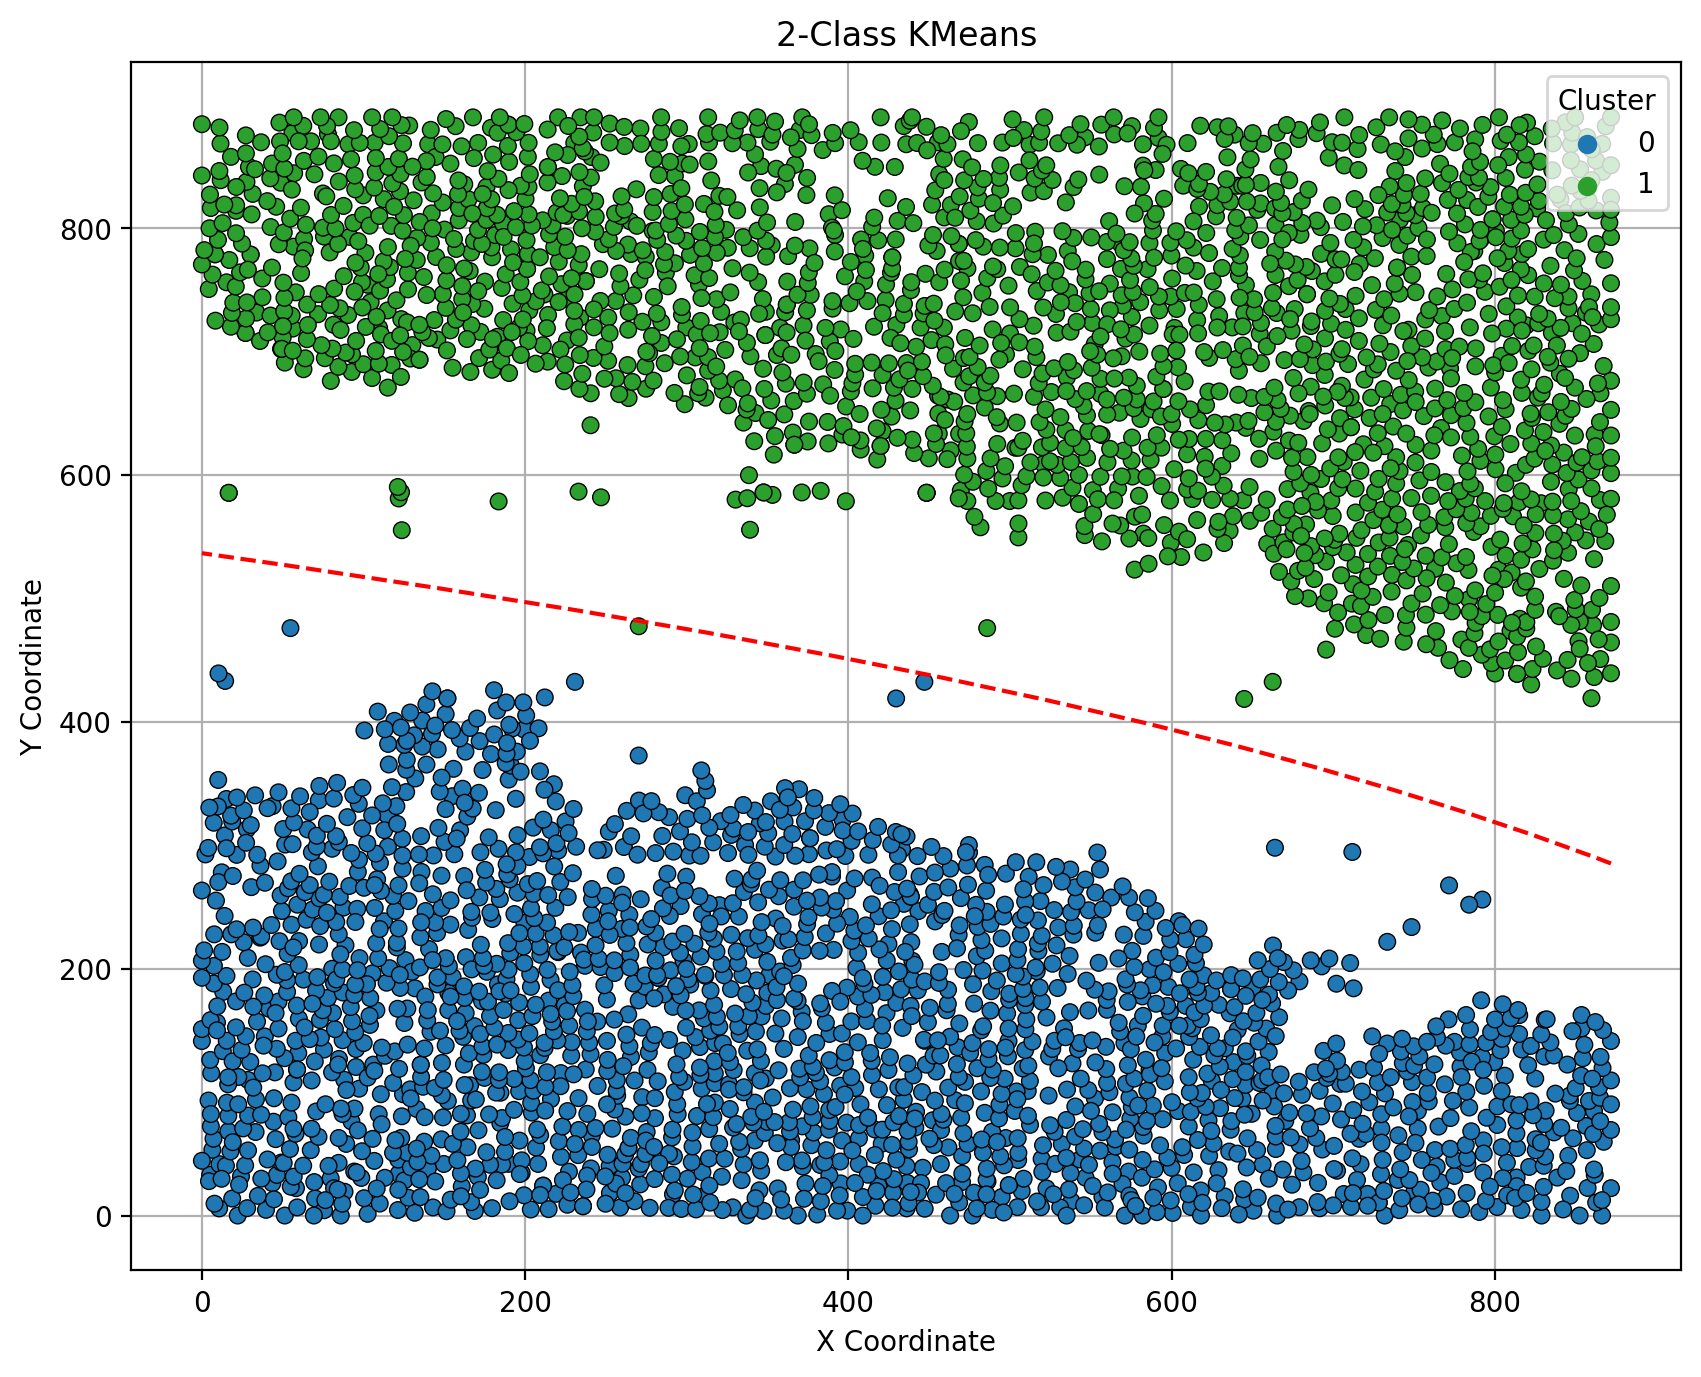

In [9]:
reload(_wh)

cut_line, t0 = _wh.estimate_cut(df)

sns.scatterplot(data=t0,
                 x='POSITION_X',
                 y='POSITION_Y',
                 hue='CLUSTER',
                 palette=['C0', 'C2'],
                 edgecolor='k')

plt.plot(cut_line[:, 0], cut_line[:, 1], c='r', ls='--')


plt.legend(loc='upper right', title='Cluster')
plt.ylabel("Y Coordinate")
plt.xlabel("X Coordinate")
plt.title("2-Class KMeans")
plt.gca().set_axisbelow(True)
plt.grid(True)


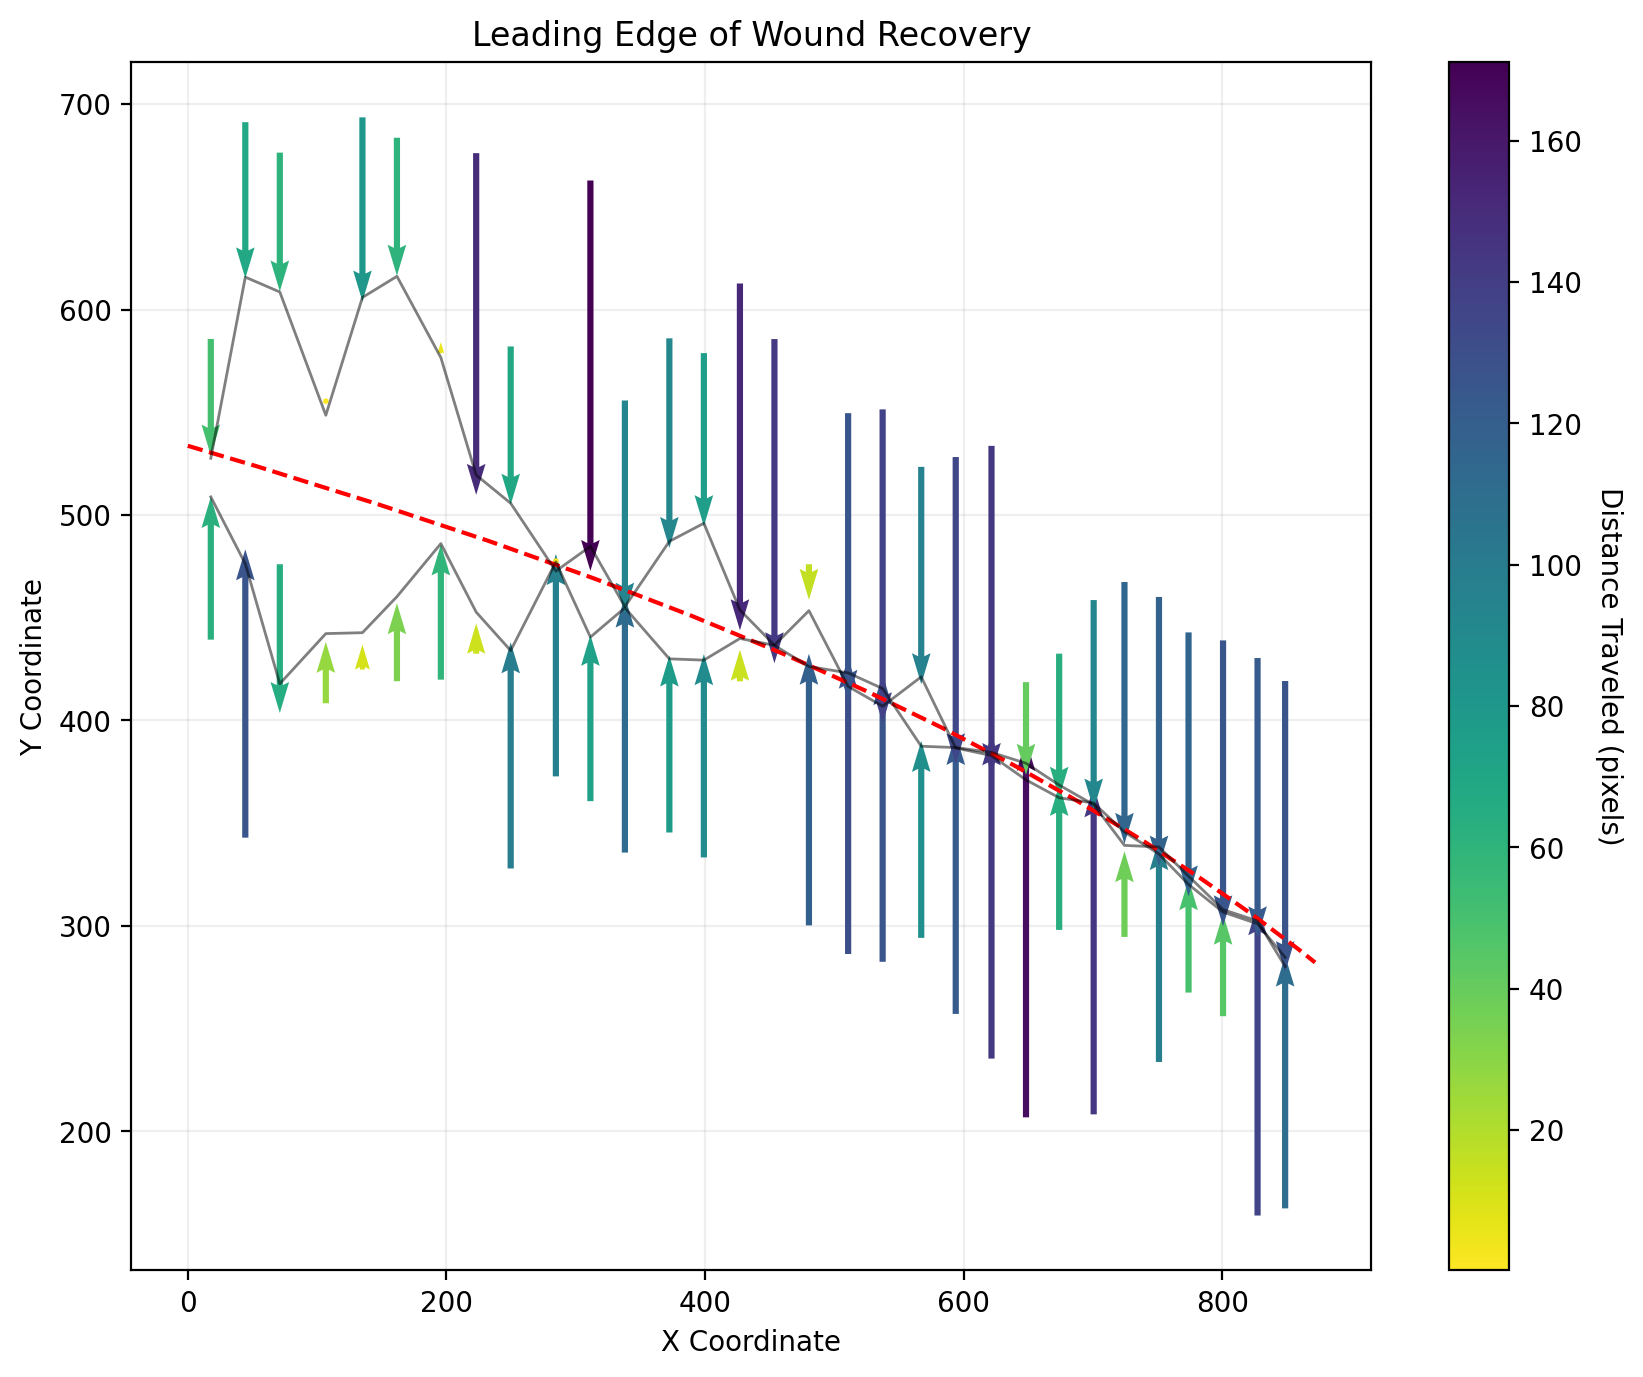

In [10]:
reload(_wh)

cmap = cm.viridis_r
n_splits = 31
cut_line, _ = _wh.estimate_cut(df) 
box = _wh.get_leading_cells(df, cut_line, n_splits)
leadingEdgePlots.velocity_shark(box, cmap)


plt.plot(cut_line[:, 0], cut_line[:, 1] -3 , c='r', ls='--')

upper = box[(box['FRAME'] == (box['FRAME'].max())) & (box['type'] == 'upper')]
plt.plot(upper['POSITION_X'], 
         upper['POSITION_Y'] - 7,
         c='k',
         lw=1,
         alpha=0.5)

lower = box[(box['FRAME'] == (box['FRAME'].max())) & (box['type'] == 'lower')]
plt.plot(lower['POSITION_X'], 
         lower['POSITION_Y'] + 7,
         c='k',
         lw=1,
         alpha=0.5)

plt.title("Leading Edge of Wound Recovery")
plt.ylabel("Y Coordinate")
plt.xlabel("X Coordinate")
plt.gca().set_axisbelow(True)
plt.grid(True, alpha=0.2)

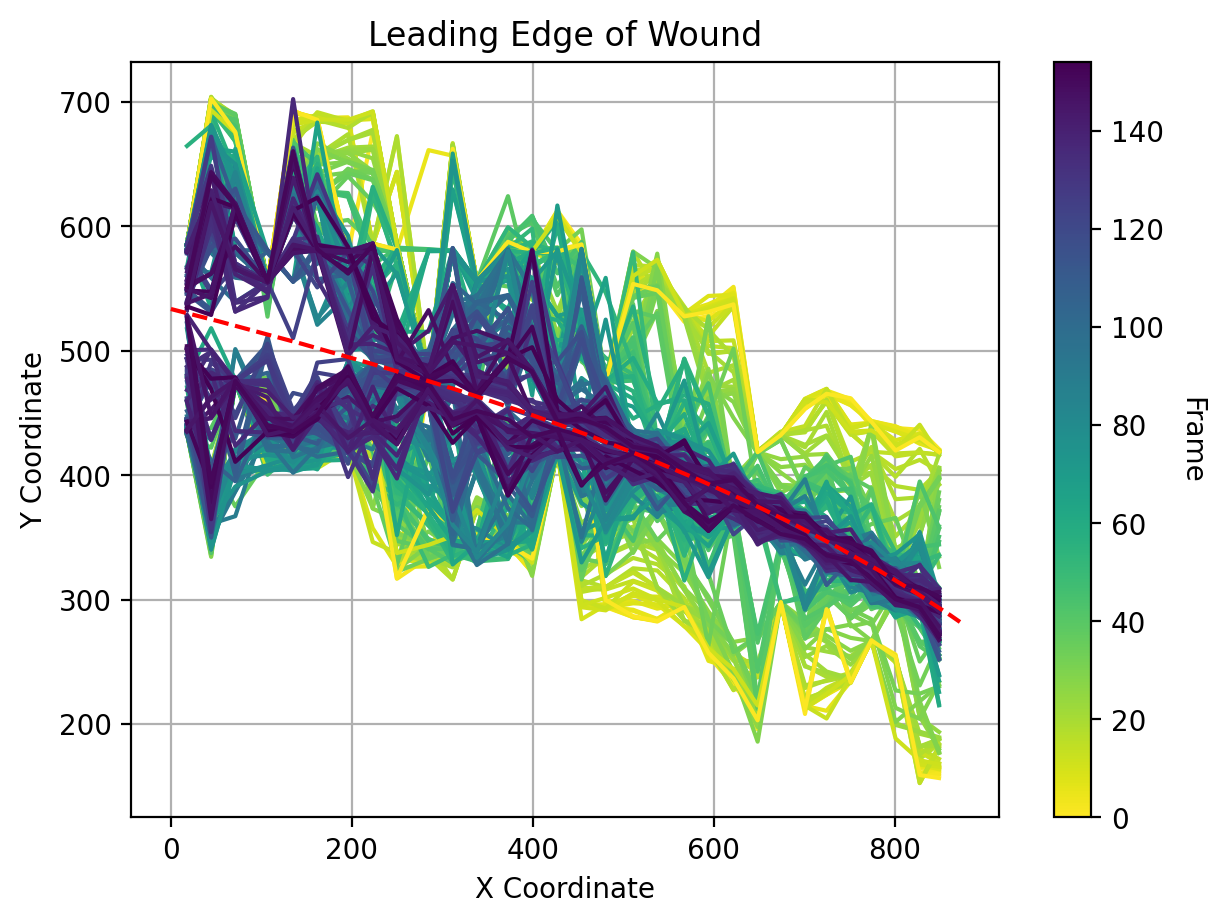

In [11]:
reload(leadingEdgePlots)

matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = (7, 5)
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['patch.facecolor'] = 'white'

cmap = cm.viridis_r

n_splits = 31
cut_line, _ = _wh.estimate_cut(df) 
box = _wh.get_leading_cells(df, cut_line, n_splits)

leadingEdgePlots.shark_plot(box, cmap)

plt.plot(cut_line[:, 0], cut_line[:, 1] -3 , c='r', ls='--')

plt.ylabel("Y Coordinate")
plt.xlabel("X Coordinate")
plt.title("Leading Edge of Wound")
plt.gca().set_axisbelow(True)
plt.grid(True)

In [15]:
reload(_wh)
cut_line, _ = _wh.estimate_cut(df) 
box = _wh.get_leading_cells(df, cut_line, n_splits)


box['X'] = box['POSITION_X'].astype(int)
box['Direction'] = np.where(box['type'] == 'upper', 'Above Wound', 'Below Wound')


box.head()

# sns.histplot(data=box, 
#              x='dist')

# box['dist_diff'] = box['dist'].diff()
# box['dist_diff'] = np.where(box['FRAME'] == 0, 0, box['dist_diff'])



# tmp = box.groupby(['X', 'Direction'], as_index=False)['dist_diff'].mean()

# sns.barplot(data=tmp,
#             x='X',
#             y='dist_diff',
#             hue='Direction',
#             palette=['C1', 'C7'])

# mean_upper = box[box['type'] == 'upper']['dist_diff'].mean()
# mean_lower = box[box['type'] == 'lower']['dist_diff'].mean()

# plt.axhline(y=mean_upper, ls=':', lw=3, c="C1")
# plt.axhline(y=mean_lower, ls=':', lw=3, c="C7")

# plt.xticks(rotation=90)
# plt.ylabel("Mean Verticle Displacement/0.25hr")
# plt.xlabel("X Coordinate")
# plt.title("Average Verticle Displacement of Leading Edge (WH06-13)")
# plt.gca().set_axisbelow(True)
# plt.grid(True, alpha=0.2)

index   Label_x      ID  TRACK_ID  QUALITY  POSITION_X  POSITION_Y  \
0   2977   ID96041   96041      3284   78.227   17.794327     585.671   
1  11326  ID113405  113405      3284   71.112   17.794327     585.828   
2  14104   ID78311   78311      3284   71.112   17.794327     585.828   
3  19213  ID138668  138668      3284   65.515   17.794327     585.716   
4  21982  ID127190  127190      4023   65.515   17.794327     585.626   

   POSITION_Z  POSITION_T  FRAME  ...  NORMED_STEP  MEAN_INTENSITY01_SCALED  \
0           0       0.000      0  ...     0.000000                      NaN   
1           0    1562.996      2  ...     0.000512                      NaN   
2           0    2344.494      3  ...     0.000768                      NaN   
3           0    3125.992      4  ...     0.001024                      NaN   
4           0    3907.490      5  ...     0.000000                      NaN   

   MEAN_INTENSITY_SCALED       dist   min_dist  BOX   type  FRAME_NORM   X  \
0                    NaN  58.804303  58.804303    1  upper    0.000000  17   
1                    NaN  58.782801  58.782801    1  upper    0.012987  17   
2                    NaN  58.782801  58.782801    1  upper    0.019481  17   
3                    NaN  58.641079  58.641079    1  upper    0.025974  17   
4                    NaN  58.555583  58.555583    1  upper    0.032468  17   

     Direction  
0  Above Wound  
1  Above Wound  
2  Above Wound  
3  Above Wound  
4  Above Wound  

[5 rows x 68 columns]

In [2]:
raise ValueError

ValueError: 

# DMD 

In [ ]:

def build_tensor(df, subregion_div):

    frame = (int(df['POSITION_X'].max()), int(df['POSITION_Y'].max()))
    
    x_iter = np.linspace(0, frame[0], subregion_div[0]+1, dtype=int)
    y_iter = np.linspace(0, frame[1], subregion_div[1]+1, dtype=int)

    
    TIME = df['FRAME'].max()
    
    T = np.zeros((TIME, subregion_div[0], subregion_div[1]))
    
    for t in range(TIME):
    
        for i, x_coord in enumerate(x_iter[1:]):
            prev_x_coord = x_iter[i]

            for j, y_coord in enumerate(y_iter[1:]):
                prev_y_coord = y_iter[j]
                
                mask = (df['POSITION_X'] >= prev_x_coord) & (df['POSITION_X'] < x_coord) & \
                (df['POSITION_Y'] >= prev_y_coord) & (df['POSITION_Y'] < y_coord) & \
                (df['FRAME'] == t)
            
                hits = len(df[mask])
            
                T[t, i, j] = hits
                
    return list(T)


    
subregion_div = (20, 20)    
tensor = build_tensor(df, subregion_div)  
plt.imshow(tensor[5], origin='lower')

In [ ]:


dmd = pydmd.DMD(svd_rank=3, tlsq_rank=3, opt=True)
dmd.fit(tensor)
dmd.plot_modes_2D(figsize=(12,5))

In [ ]:
for i, mode in enumerate(dmd.modes.T):
    plt.plot(range(400), mode.real)
    plt.title('Modes')
plt.show()

for dynamic in dmd.dynamics:
    plt.plot(range(154), dynamic.real)
    plt.title('Dynamics')
plt.show()

In [ ]:
compute_integral = scipy.integrate.trapz

dmd_states = [state.reshape(tensor[0].shape) for state in dmd.reconstructed_data.T]

original_int = [compute_integral(compute_integral(t)).real for t in tensor]
dmd_int = [compute_integral(compute_integral(state)).real for state in dmd_states]

matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = (15, 5)

plt.plot(dmd.original_timesteps, original_int, 'bo', label='original snapshots')
plt.plot(dmd.dmd_timesteps, dmd_int, 'r.', label='dmd states')
plt.ylabel('Integral')
plt.xlabel('Time')
plt.grid()
leg = plt.legend()

In [ ]:
img = np.expand_dims(np.asarray(tensor), 1)

fig = px.imshow(img, 
                animation_frame=0, 
                facet_col=1, 
                color_continuous_scale='RdBu_r')
fig.show()

# 3D Plots

In [ ]:
reload(_stat)

SIZE = 18
FRAME_SIZE = (df['POSITION_X'].max(), df['POSITION_Y'].max())

df['POSITION_X_INT'] = df['POSITION_X'].astype(int)
df['POSITION_Y_INT'] = df['POSITION_Y'].astype(int)

hieght = df.groupby(['POSITION_X_INT', 'POSITION_Y_INT', 'FRAME'], as_index=False)['TRACK_ID'].count()
hieght.columns = ['POSITION_X', 'POSITION_Y', 'FRAME', 'COUNT']
hieght.head()

x, y, z = _stat.count_rescaler(hieght, FRAME_SIZE, (SIZE, SIZE))

matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = (8, 6)
ax = plt.axes(projection='3d')
ax.plot_trisurf(x, y, z, cmap='viridis')

ax.view_init(50, -35)
ax.dist = 11

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Number of Trajectories')
plt.title("Total Cell Trajectories Through Each Point")

In [ ]:
#DISTANCE FUNCTION
def distance(x1,y1,x2,y2):
    d=np.sqrt((x1-x2)**2+(y1-y2)**2)
    return d

#CREATING IDW FUNCTION
def idw_npoint(xz,yz,n_point,p):
    r=10 #block radius iteration distance
    nf=0
    while nf<=n_point: #will stop when np reaching at least n_point
        x_block=[]
        y_block=[]
        z_block=[]
        r +=10 # add 10 unit each iteration
        xr_min=xz-r
        xr_max=xz+r
        yr_min=yz-r
        yr_max=yz+r
        for i in range(len(x)):
            # condition to test if a point is within the block
            if ((x[i]>=xr_min and x[i]<=xr_max) and (y[i]>=yr_min and y[i]<=yr_max)):
                x_block.append(x[i])
                y_block.append(y[i])
                z_block.append(z[i])
        nf=len(x_block) #calculate number of point in the block
    
    #calculate weight based on distance and p value
    w_list=[]
    for j in range(len(x_block)):
        d=distance(xz,yz,x_block[j],y_block[j])
        if d>0:
            w=1/(d**p)
            w_list.append(w)
            z0=0
        else:
            w_list.append(0) #if meet this condition, it means d<=0, weight is set to 0
    
    #check if there is 0 in weight list
    w_check=0 in w_list
    if w_check==True:
        idx=w_list.index(0) # find index for weight=0
        z_idw=z_block[idx] # set the value to the current sample value
    else:
        wt=np.transpose(w_list)
        z_idw=np.dot(z_block,wt)/sum(w_list) # idw calculation using dot product
    return z_idw


# POPULATE INTERPOLATION POINTS
n=100 #number of interpolation point for x and y axis
x_min=min(x)
x_max=max(x)
y_min=min(y)
y_max=max(y)
w=x_max-x_min #width
h=y_max-y_min #length
wn=w/n #x interval
hn=h/n #y interval

#list to store interpolation point and elevation
y_init=y_min
x_init=x_min
x_idw_list=[]
y_idw_list=[]
z_head=[]
for i in range(n):
    xz=x_init+wn*i
    yz=y_init+hn*i
    y_idw_list.append(yz)
    x_idw_list.append(xz)
    z_idw_list=[]
    for j in range(n):
        xz=x_init+wn*j
        z_idw=idw_npoint(xz,yz,5,1.5) #min. point=5, p=1.5
        z_idw_list.append(z_idw)
    z_head.append(z_idw_list)
    
print("done")

In [3]:
# CREATING 3D TERRAIN MODEL
fig=go.Figure()
fig.add_trace(go.Surface(z=z_head,x=x_idw_list,y=y_idw_list))
fig.update_layout(scene=dict(aspectratio=dict(x=2, y=2, z=0.5),
                             xaxis = dict(range=[x_min,x_max],),
                             yaxis = dict(range=[y_min,y_max])))

go_offline.plot(fig, 
                filename='figs/WH06_terrain_diff.html',
                validate=True, 
                auto_open=False)

NameError: name 'go' is not defined

In [ ]:
fig = go.Figure(data =
    go.Contour(   
        z=z,
        x=x, # horizontal axis
        y=y, # vertical axis
        colorscale='Viridis'
    ))

fig.update_layout(
    title={
        'text': "Contour Plot Of Trajectories",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="X Coordinate",
    yaxis_title="Y Coordinate",
    legend_title="Count of Trajectories",
    showlegend=True)


go_offline.plot(fig, 
                filename='figs/WH04_contour_diff.html',
                validate=True, 
                auto_open=False)

fig.write_image("figs/WH04_contour_diff.png")